In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kmedoids import KMedoids
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.express as px
import pickle

In [2]:
X = pd.read_csv('../../../data/processed/role_scores_normalized.csv')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [3]:
k2_model = KMedoids(n_clusters=2, metric='cosine', random_state=42)
k2_model.fit(X_scaled)

final_labels = k2_model.labels_
medoid_indices = k2_model.medoid_indices_
medoids = X_scaled[medoid_indices]

In [4]:
df_engineered = pd.read_csv('../../../data/processed/role_scores_normalized.csv')
df_meta = pd.read_csv('../../../data/processed/meta_data.csv')
df_engineered["Cluster"] = final_labels
df_with_clusters = df_meta.join(df_engineered[["Cluster"]])

In [5]:
df_medoids = df_with_clusters.iloc[medoid_indices].copy()

In [6]:
print("\nRepresentative medoid players per cluster:")
print(df_medoids[["Name", "Club", "Nat", "Age", "CA", "PA", "Cluster"]])

print("\nCluster sizes:")
print(df_engineered["Cluster"].value_counts().sort_index())


Representative medoid players per cluster:
                  Name      Club  Nat  Age   CA   PA  Cluster
1310  Charlie Trustram     Luton  ENG   16   45   88        0
331               Samú  Mallorca  POR   22  138  153        1

Cluster sizes:
Cluster
0    1062
1     759
Name: count, dtype: int64


In [7]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

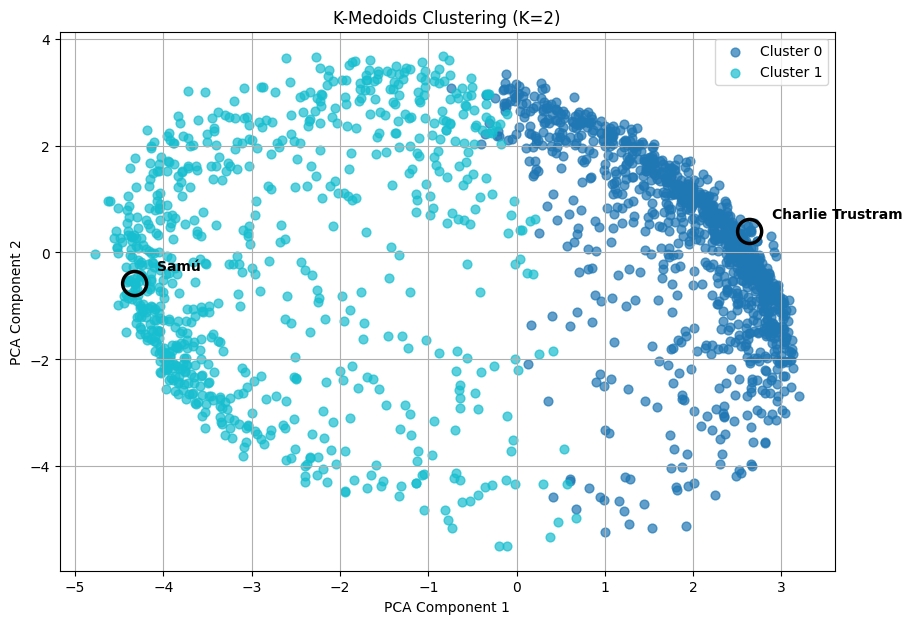

In [8]:
clusters = np.unique(final_labels)

plt.figure(figsize=(10, 7))
colors = plt.cm.tab10(np.linspace(0, 1, len(clusters)))

for cluster, color in zip(clusters, colors):
    mask = (final_labels == cluster)
    plt.scatter(
        X_pca[mask, 0], 
        X_pca[mask, 1], 
        s=40, 
        c=[color], 
        label=f"Cluster {cluster}", 
        alpha=0.70
    )

for i, m in enumerate(medoid_indices):
    plt.scatter(
        X_pca[m, 0], 
        X_pca[m, 1], 
        s=300, 
        edgecolors="black",
        facecolors="none", 
        linewidths=2.5, 
        marker="o"
    )
    # Add player name next to medoid
    name = df_with_clusters.iloc[m]["Name"]
    plt.text(
        X_pca[m, 0]+0.25, 
        X_pca[m, 1]+0.25, 
        name, 
        fontsize=10, 
        fontweight="bold"
    )

plt.title(f'K-Medoids Clustering (K=2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
df_plot = pd.DataFrame({
    "x": X_pca[:, 0],
    "y": X_pca[:, 1],
    "Cluster": final_labels,
    "Name": df_with_clusters["Name"].values,
    "Club": df_with_clusters["Club"].values,
    "CA": df_with_clusters["CA"].values,
    "PA": df_with_clusters["PA"].values,
})

df_plot["is_medoid"] = False
df_plot.loc[medoid_indices, "is_medoid"] = True

fig = px.scatter(
    df_plot,
    x="x",
    y="y",
    color="Cluster",
    hover_data=["Name", "Club", "CA", "PA"],
    title=f"K-Medoids Clustering (K=2) - PCA Projection",
    opacity=0.8,
)

medoids_df = df_plot[df_plot["is_medoid"]]

fig.add_scatter(
    x=medoids_df["x"],
    y=medoids_df["y"],
    mode="markers+text",
    marker=dict(
        size=18,
        symbol="circle-open",
        line=dict(width=2, color="black"),
    ),
    text=medoids_df["Name"],
    textposition="top center",
    hoverinfo="text",
    name="Medoids",
)

fig.update_layout(
    xaxis_title="PCA Component 1",
    yaxis_title="PCA Component 2",
    legend_title="Cluster",
)

fig.show()

In [10]:
for c in df_with_clusters["Cluster"].unique():
    print(f"\n=== Cluster {c}: Top 10 by CA ===")
    display(
        df_with_clusters[df_with_clusters["Cluster"] == c]
        [["Name","Club","CA","PA"]]
        .sort_values("CA", ascending=False)
        .head(10)
    )


=== Cluster 0: Top 10 by CA ===


,Name,Club,CA,PA
0,Harry Kane,FC Bayern,184,185
1,Jude Bellingham,R. Madrid,177,188
9,Martin Ødegaard,Arsenal,173,180
5,Luka Modrić,R. Madrid,171,180
7,Bruno Fernandes,Man UFC,171,174
3,Leroy Sané,FC Bayern,169,172
14,İlkay Gündoğan,Barcelona,167,167
15,Frenkie de Jong,Barcelona,165,181
27,Bruno Guimarães,Newcastle,165,170
10,Thiago,Liverpool,163,173



=== Cluster 1: Top 10 by CA ===


,Name,Club,CA,PA
6,Declan Rice,Arsenal,176,182
2,Joshua Kimmich,FC Bayern,174,183
8,Eduardo Camavinga,R. Madrid,170,180
11,Federico Valverde,R. Madrid,168,175
4,Nicolò Barella,Inter,161,169
31,Reece James,Chelsea,161,170
20,David Alaba,R. Madrid,159,174
26,Koke,A. Madrid,157,162
38,Sandro Tonali,Newcastle,157,171
136,Yves Bissouma,Tottenham,157,165


In [11]:
df_with_clusters.groupby("Cluster")["Age"].mean()

Cluster
0    19.684557
1    21.740448
Name: Age, dtype: float64

In [12]:
df_with_clusters.groupby("Cluster")["PA"].median()

Cluster
0    121.5
1    132.0
Name: PA, dtype: float64

In [13]:
df_with_clusters.groupby("Cluster")["CA"].median()

Cluster
0     78.0
1    112.0
Name: CA, dtype: float64

In [14]:
df_with_clusters.groupby("Cluster")["Name"].count()

Cluster
0    1062
1     759
Name: Name, dtype: int64

In [16]:
cols = ['M_A_Score','M_S_Score',
    'CM_A_Score','CM_S_Score','CM_D_Score','CM_Au_Score',
    'AP_A_Score','AP_S_Score',
    'DLP_S_Score','DLP_D_Score',
    'RP_S_Score','C_S_Score',
    'B2B_S_Score',
    'BWM_S_Score','BWM_D_Score']
df_engineered.groupby("Cluster")[cols].mean()

,M_A_Score,M_S_Score,CM_A_Score,CM_S_Score,CM_D_Score,CM_Au_Score,AP_A_Score,AP_S_Score,DLP_S_Score,DLP_D_Score,RP_S_Score,C_S_Score,B2B_S_Score,BWM_S_Score,BWM_D_Score
Cluster,,,,,,,,,,,,,,,
0,0.732963,0.576018,0.609584,0.197430,-1.258234,0.274374,0.855733,0.730015,0.459408,0.372123,0.334678,-0.481513,-0.591964,-1.196245,-1.614370
1,-0.998892,-0.219750,0.057940,0.653115,0.393985,0.455392,-0.765357,-0.849975,-0.143968,0.231446,-0.244879,0.303762,-0.347272,0.823764,0.650691


In [17]:
cluster_means_k2 = df_engineered.groupby("Cluster")[cols].mean()
feature_diff = cluster_means_k2.max(axis=0) - cluster_means_k2.min(axis=0)
top10_diff = feature_diff.sort_values(ascending=False).head(10)

print(top10_diff)

BWM_D_Score    2.265061
BWM_S_Score    2.020009
M_A_Score      1.731855
CM_D_Score     1.652219
AP_A_Score     1.621090
AP_S_Score     1.579990
M_S_Score      0.795768
C_S_Score      0.785274
DLP_S_Score    0.603376
RP_S_Score     0.579558
dtype: float64
